In [1]:
!pip install langchain
!pip install langgraph

  Using cached langchain_core-0.2.41-py3-none-any.whl.metadata (6.2 kB)
  Using cached langgraph_checkpoint-1.0.12-py3-none-any.whl.metadata (4.6 kB)
Using cached langchain_core-0.2.41-py3-none-any.whl (397 kB)
Using cached langgraph_checkpoint-1.0.12-py3-none-any.whl (17 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.9
    Uninstalling langchain-core-0.3.9:
      Successfully uninstalled langchain-core-0.3.9
  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 2.0.1
    Uninstalling langgraph-checkpoint-2.0.1:
      Successfully uninstalled langgraph-checkpoint-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.2.2 requires langchain-core<0.4.0,>=0.3.9, but you have langchain-core 0.2.41 which is incompatible.
langchain 0.3.2 requires langchain-c

In [7]:
!pip install langgraph-checkpoint-sqlite

In [12]:
!pip install --upgrade langchain

In [13]:
pip install --upgrade langchain_openai


Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install --upgrade langgraph

In [1]:
import os
import yaml
with open('chatgpt-api-credentials.yml') as file:
    openai_key = yaml.safe_load(file)
with open('tavily-api-credentials.yml') as file:
    tavilyai_key = yaml.safe_load(file)
with open('weather-api-credentials.yml') as file:
    weather_key = yaml.safe_load(file)
os.environ['OPENAI_API_KEY'] = openai_key['OPENAI-API-KEY']
os.environ['TAVILY_API_KEY'] = tavilyai_key['TAVILY-API-KEY']
weather_api = weather_key['WEATHER-API-KEY']

In [2]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool

from typing_extensions import TypedDict
from typing import Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


In [3]:
memory = SqliteSaver.from_conn_string("memory.db")

In [15]:
memory

In [4]:
import requests
tv_search = TavilySearchResults(max_results=3)

@tool
def search_web(query: str) -> list:
    """Search the web for a query."""
    results = tv_search.invoke(query)
    return results

@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={weather_api}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"


In [5]:
tools = [search_web, get_weather]
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.3)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot",tools_condition,)
graph_builder.add_edge("tools","chatbot")


In [12]:
graph = graph_builder.compile(checkpointer=memory)



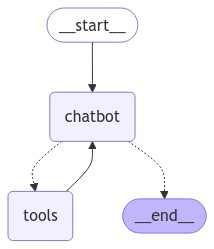

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [13]:
def chat_with_agent(prompt: str, session_id: str):
    response = graph.invoke({"messages":[('user', prompt)]},
                            {"configurable":{'thread_id':session_id}})
    display(Markdown(response['messages'][-1].content))

In [14]:
user = "praveen"
prompt = " What is 2*3?"
chat_with_agent(prompt=prompt,session_id=user)

AttributeError: '_GeneratorContextManager' object has no attribute 'get_next_version'